# Super restriction factor hypermutation analysis
### Kate H. D. Crawford and Adam S. Dingens 
### In collabortation with Mollie McDonnell and Michael Emerman

Analysis performed by Adam Dingens and Kate Crawford in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019. Cell culture experiments performed by Mollie McDonnell, and sequencing prep performed by Mollie with Adam's guidance.


## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import doctest
import re
import tempfile
import gzip
import itertools
import random

import pandas as pd
import numpy as np

from ast import literal_eval
from plotnine import *
from IPython.display import display, HTML, Image

import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
from dms_tools2.ipython_utils import showPDF
from dms_tools2.utils import getSubstitutions

import dmslogo
from dmslogo.colorschemes import CBPALETTE

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('webagg')
%matplotlib inline

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory. This has previously been named "results_1and1b" to keep trakc of what sequencing data was used.
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 2

# do we use existing results or generate everything new?
use_existing = "yes"

Using dms_tools2 version 2.6.5


# Download the sequencing data from the Sequence Read Archive
Sequencing reads were deposited to the NCBI SRA under accesion number [PRJNA605864](https://www.ncbi.nlm.nih.gov/sra/PRJNA605864).

In [2]:
samples = pd.DataFrame.from_records(
        [('PLASMIDCTRL','SRR11059589'),
         ('NoA3_1','SRR11059588'),
         ('A3G_1','SRR11059577'),
         ('A3C_1','SRR11059573'),
         ('A3CE68A_1','SRR11059572'),
         ('COTD_1','SRR11059571'),
         ('COTDE254A_1','SRR11059570'),
         ('COTDE68AE254A_1','SRR11059569'),
         ('I188_1','SRR11059568'),
         ('I188E68A_1','SRR11059567'),
         ('COII_1','SRR11059587'),
         ('COIIE68AE254A_1','SRR11059586'),
         ('NoA3_2','SRR11059585'),
         ('A3G_2','SRR11059584'),
         ('A3C_2','SRR11059583'),
         ('A3CE68A_2','SRR11059582'),
         ('COTD_2','SRR11059581'),
         ('COTDE254A_2','SRR11059580'),
         ('COTDE68AE254A_2','SRR11059579'),
         ('I188_2','SRR11059578'),
         ('I188E68A_2','SRR11059576'),
         ('COII_2','SRR11059575'),
         ('COIIE68AE254A_2','SRR11059574')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera= None#(
        #    '/app/aspera-connect/3.7.5/bin/ascp', # valid path to ascp on Hutch server
        #    '/app/aspera-connect/3.7.5/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
        #    ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

INFO:numexpr.utils:Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


KeyboardInterrupt: 

## Define samples from FASTQ_files

R1fastqfilelist_df = pd.read_csv("./data/samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

In [2]:
samplenames = ["PLASMIDCTRL", "NoA3_1", "A3G_1", "A3C_1", "A3CE68A_1", "COTD_1", "COTDE254A_1", "COTDE68AE254A_1", "I188_1", "I188E68A_1", "COII_1", "COIIE68AE254A_1", "NoA3_2", "A3G_2", "A3C_2", "A3CE68A_2", "COTD_2", "COTDE254A_2", "COTDE68AE254A_2", "I188_2", "I188E68A_2", "COII_2", "COIIE68AE254A_2"]
R1_df = pd.DataFrame({'name':samplenames})
R1_df["R1"] = R1_df['name'].astype(str) + "_R1.fastq.gz"
R1_df["name"] = R1_df['name'].str.replace("_", "-")

print(R1_df)

INFO:numexpr.utils:Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


               name                           R1
0       PLASMIDCTRL      PLASMIDCTRL_R1.fastq.gz
1            NoA3-1           NoA3-1_R1.fastq.gz
2             A3G-1            A3G-1_R1.fastq.gz
3             A3C-1            A3C-1_R1.fastq.gz
4         A3CE68A-1        A3CE68A-1_R1.fastq.gz
5            COTD-1           COTD-1_R1.fastq.gz
6       COTDE254A-1      COTDE254A-1_R1.fastq.gz
7   COTDE68AE254A-1  COTDE68AE254A-1_R1.fastq.gz
8            I188-1           I188-1_R1.fastq.gz
9        I188E68A-1       I188E68A-1_R1.fastq.gz
10           COII-1           COII-1_R1.fastq.gz
11  COIIE68AE254A-1  COIIE68AE254A-1_R1.fastq.gz
12           NoA3-2           NoA3-2_R1.fastq.gz
13            A3G-2            A3G-2_R1.fastq.gz
14            A3C-2            A3C-2_R1.fastq.gz
15        A3CE68A-2        A3CE68A-2_R1.fastq.gz
16           COTD-2           COTD-2_R1.fastq.gz
17      COTDE254A-2      COTDE254A-2_R1.fastq.gz
18  COTDE68AE254A-2  COTDE68AE254A-2_R1.fastq.gz
19           I188-2 

## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [5]:
fastqdir = "./results/FASTQ_files/"
refseq = './data/Bru_Pol.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) #was 204,504,34,34 #these need to be updated 179,529,25,25


# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
PLASMIDCTRL,PLASMIDCTRL_R1.fastq.gz
NoA3-1,NoA3-1_R1.fastq.gz
A3G-1,A3G-1_R1.fastq.gz
A3C-1,A3C-1_R1.fastq.gz
A3CE68A-1,A3CE68A-1_R1.fastq.gz
COTD-1,COTD-1_R1.fastq.gz
COTDE254A-1,COTDE254A-1_R1.fastq.gz
COTDE68AE254A-1,COTDE68AE254A-1_R1.fastq.gz
I188-1,I188-1_R1.fastq.gz
I188E68A-1,I188E68A-1_R1.fastq.gz


In [6]:

#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 17 \
        --fastqdir {fastqdir} \
        --maxmuts 33 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

# need to edit

# Kate picked a `maxmuts` of 33. There are 100 possible codons that could be mutated, so that's a max of about one third of the codons being mutated.
# When `maxmuts` was 50, there was a cluster of reads in all samples with ~100 substitutions that seemed to come from missaligning. 



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [7]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

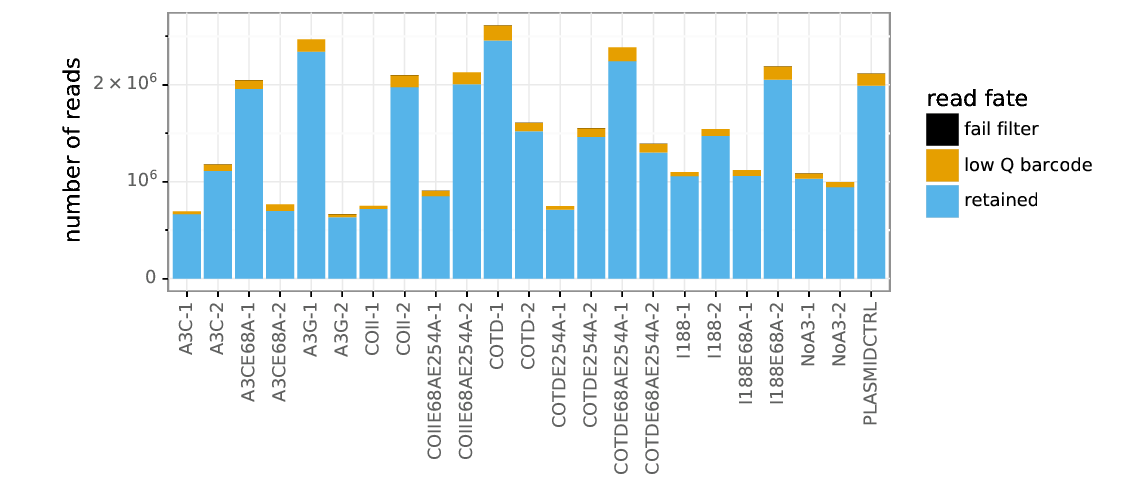

In [8]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

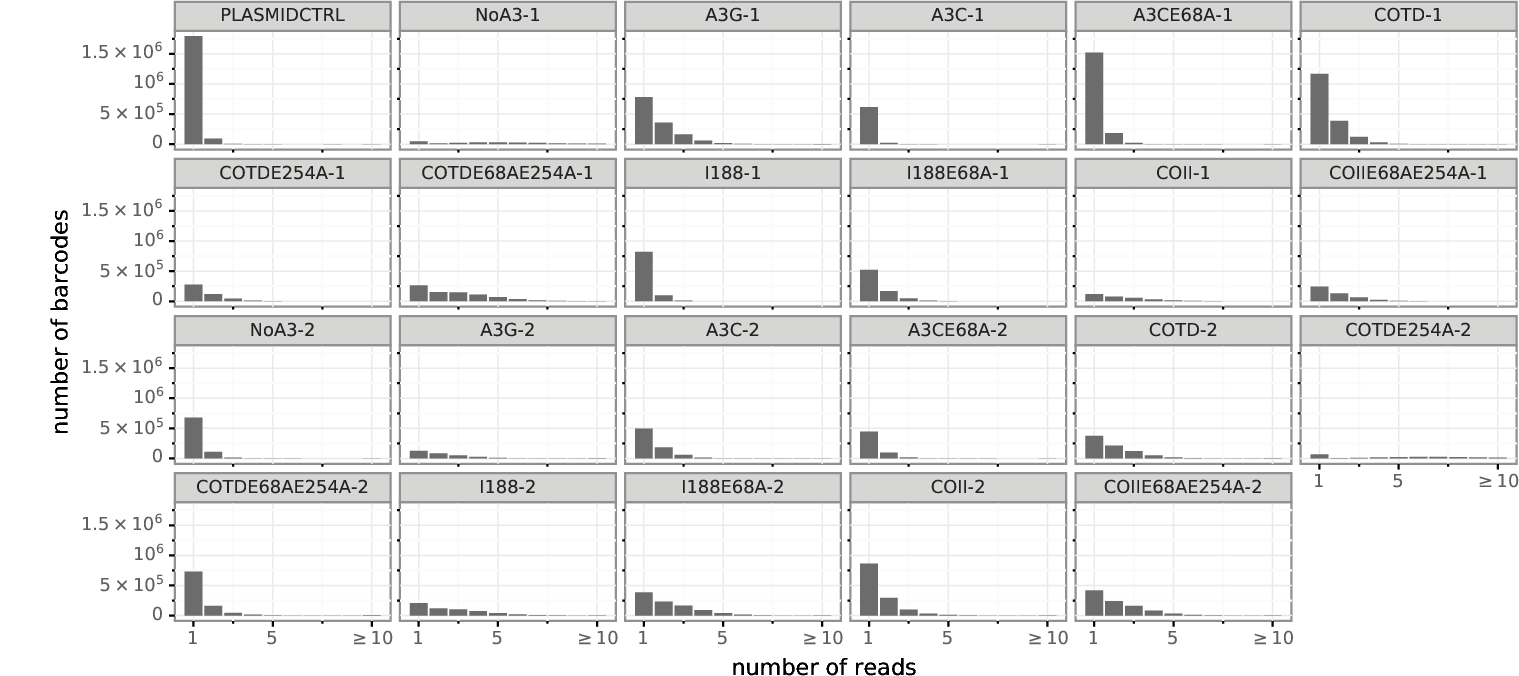

In [9]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

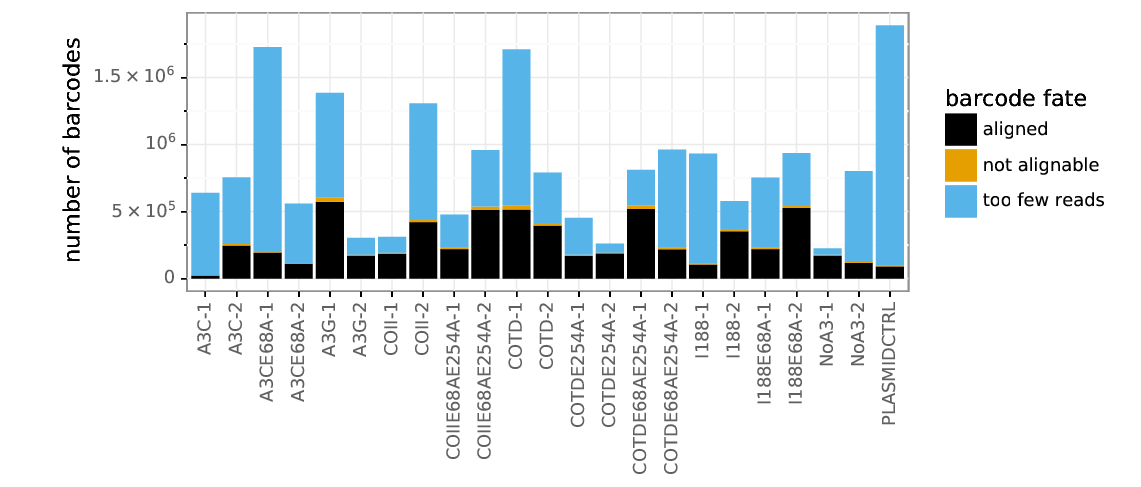

In [10]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

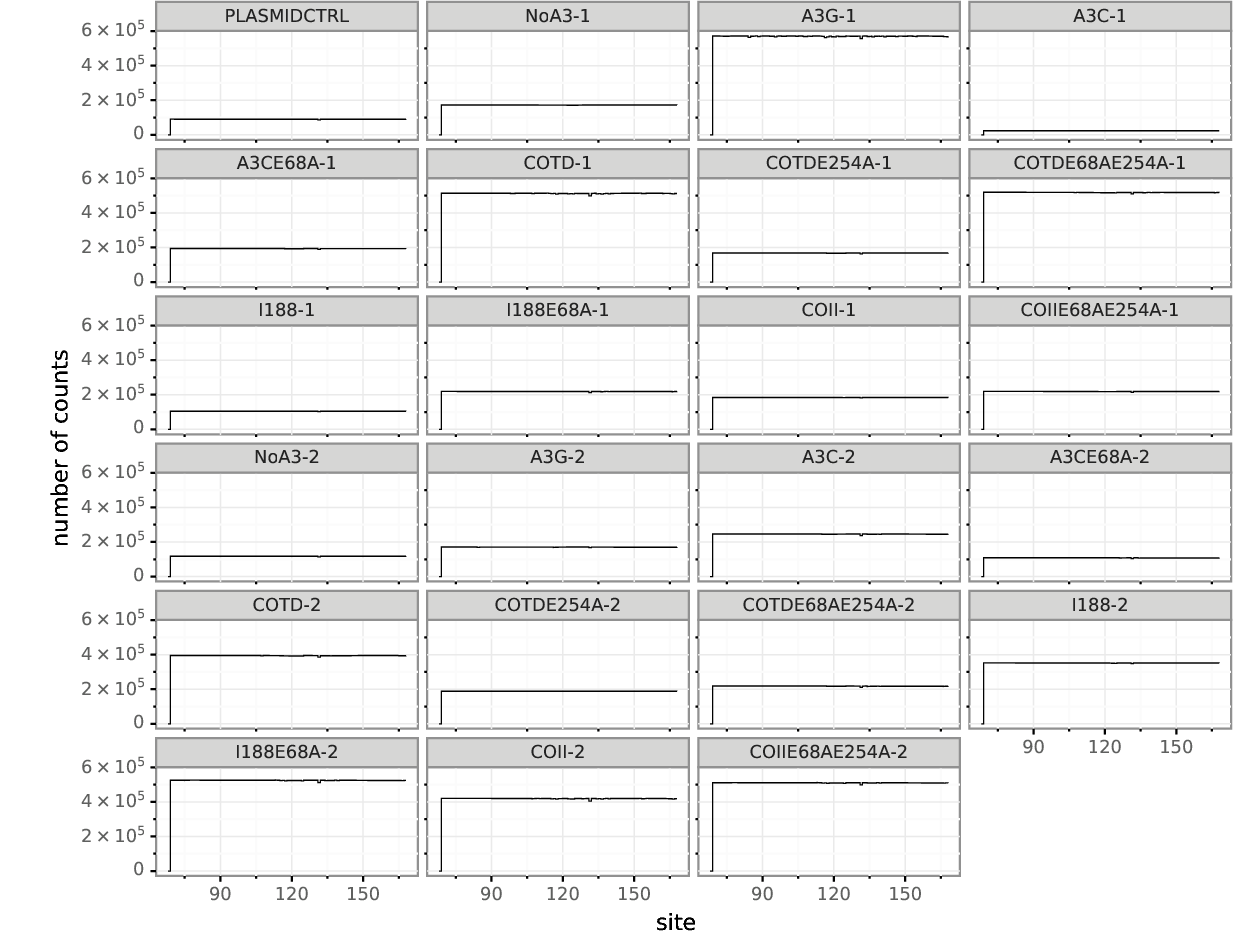

In [11]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

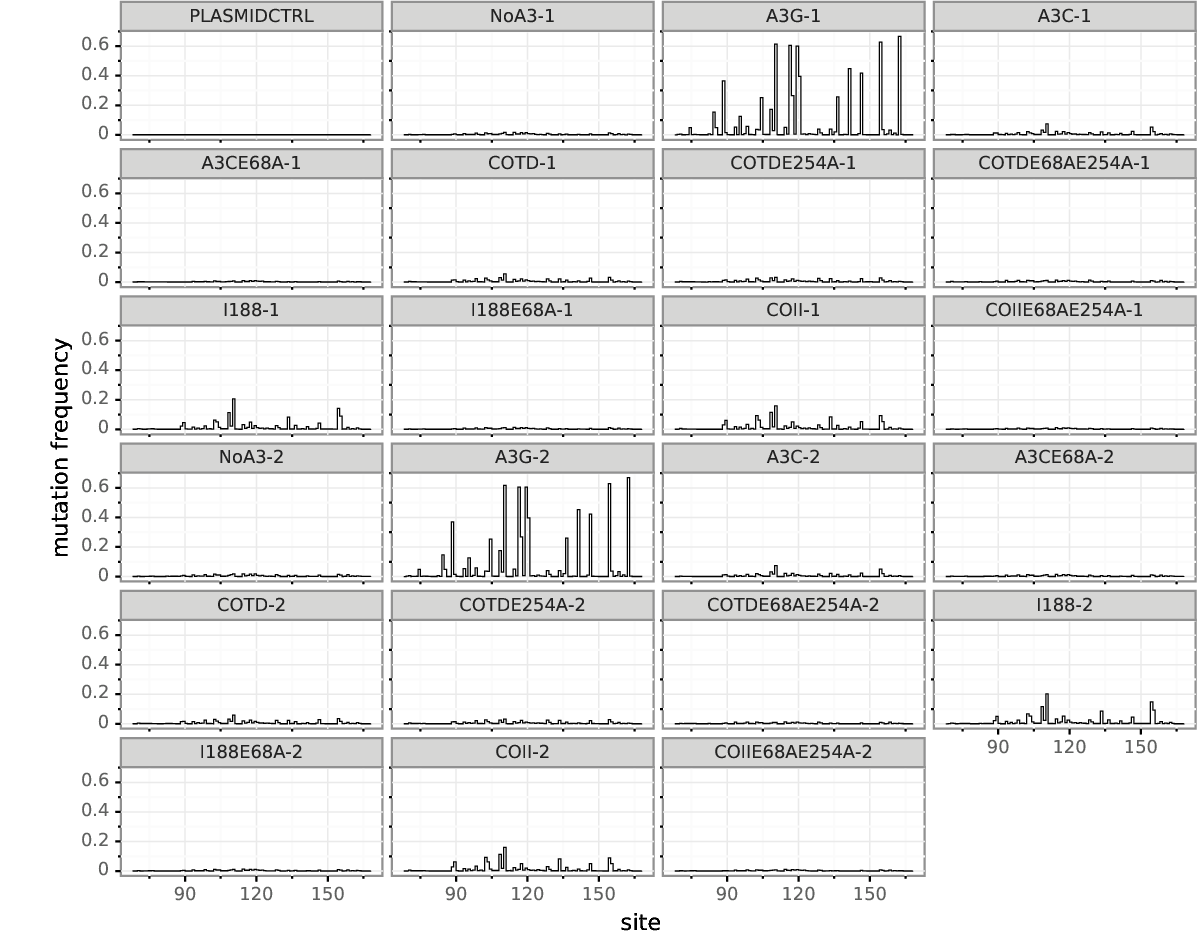

In [12]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 

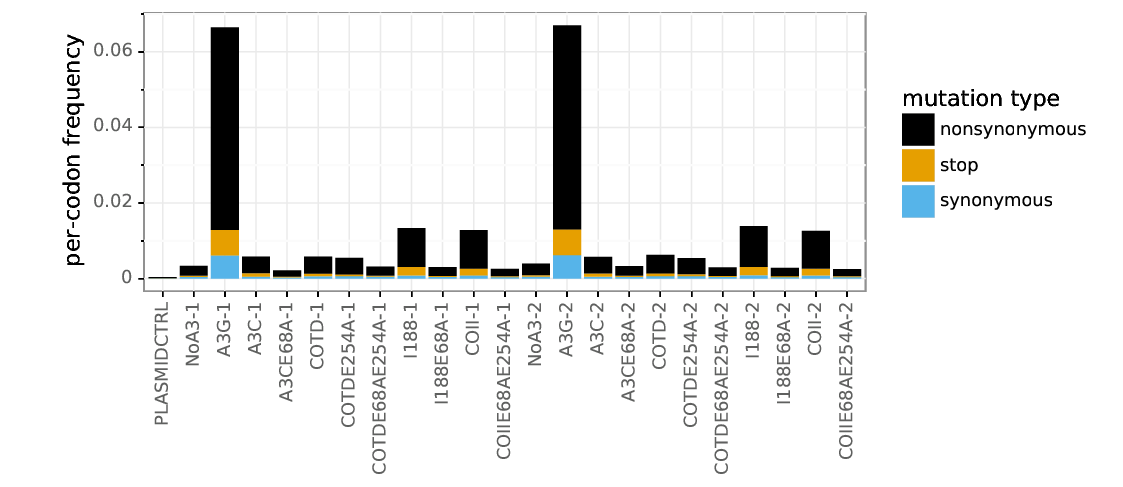

In [13]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

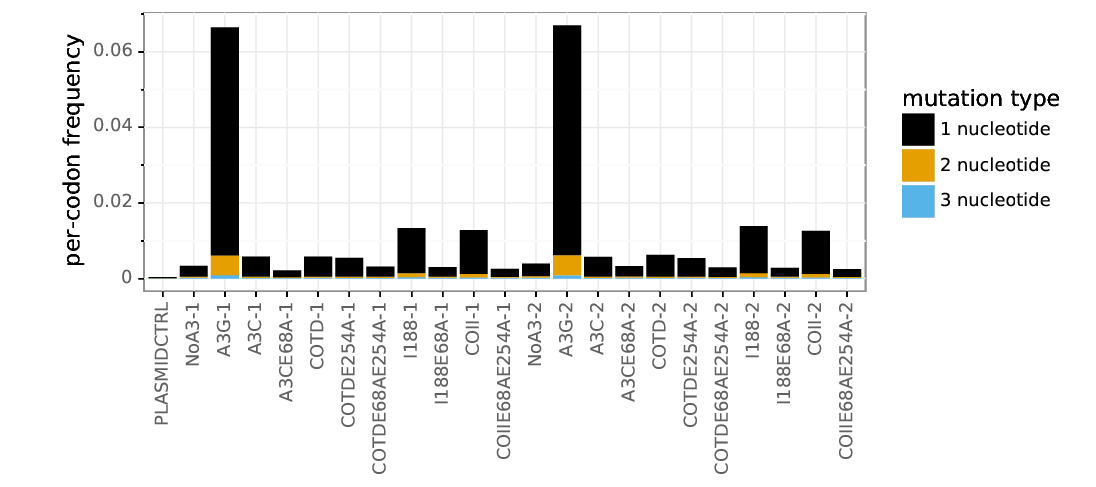

In [14]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

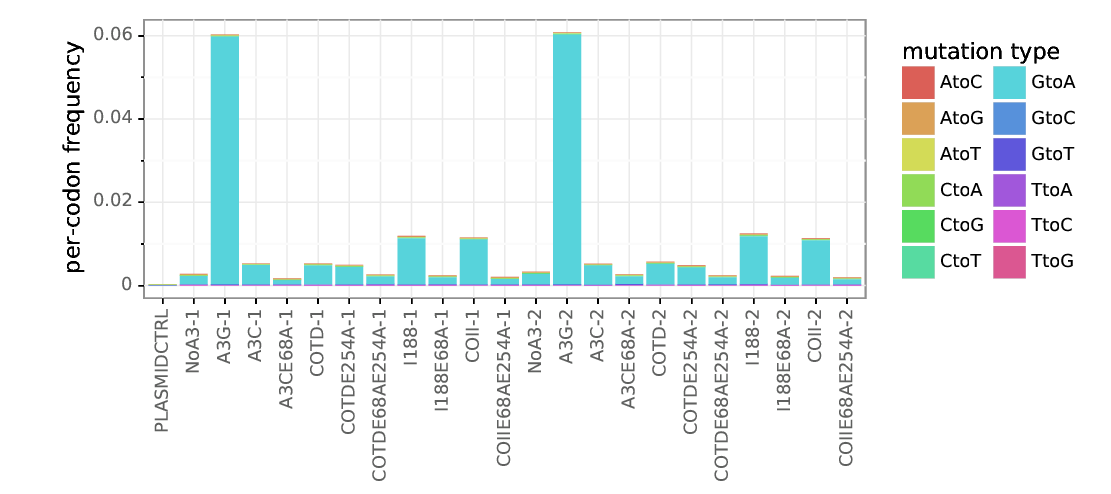

In [15]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

# Analyze `bcinfo.csv.gz` output

The analysis below uses the `.csv` output of the `bcinfo file`.

The main outputs are: 

1. bar plots (and line plots) of the percent of reads in each sample with a given number of substitutions (all substitutions or subset on G->A subs).

2. Heat maps of the most frequent nucleotides on the 5' and 3' side of a substitution. 

3. Logo plots of what nucleotides are more likely to be mutated and what the 5' and 3' nucleotides are likely to be.

Note: After looking at sequences with large number of mutations (>10) in the non-A3G samples, it became clear that a substantial portion of reads were simply misaligned in the overlap region between R1 and R2, which was resulting in an artificially high number of mutations for some reads. 

In order to correct for this, I extracted the 40 bp in the middle of the gene (from bp 130 to 170), masked all Gs, resulting in 28 nucleotides and counted the number of substitutions in each sequence at those 28 sites. I then threw out all sequences with > 3 substitutions at those 28 non-G sites. 

In [16]:
# These next three cells define functions for processing reads.

NTS = ('A', 'C', 'T', 'G', 'N')

def getSubstitutions_Nokay(mutant, wildtype):
    """Get space delimited string of substitutions

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence. This does not record 'N' mutations.

    >>> getSubstitutions_Nokay('AGT', 'TGT')
    'A1T'
    >>> getSubstitutions_Nokay('AAGTAACGA', 'ATCTAACGA')
    'A2T G3C'
    >>> getSubstitutions_Nokay('TGNC', 'AGTC')
    'T1A'
    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs

In [17]:
def getSubstitutions_Nokay_maskG(mutant, wildtype):
    """Get space delimited string of substitutions not at Gs

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence. This does not record 'N' mutations.

    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if wt == 'G':
            continue
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs

In [18]:
NTS_noN = 'ACTG'
def motif_counts(seq):
    motif_counts = {}
    possible_motifs = itertools.product(NTS_noN, repeat=3)
    for motif in possible_motifs:
        motif = ('').join(motif)
        motif_counts[motif] = seq.count(motif)
    return(motif_counts)

def get_n_subs(subs_str):
    if subs_str == '':
        return(0)
    else:
        return(len(subs_str.split(' ')))

def get_n_ga_subs(subs_str):
    """Return number of substitutions that are G->A subs"""
    if subs_str == '':
        return(0)
    else:
        subs_list = subs_str.split(' ')
        num_ga = 0
        for sub in subs_list:
            if (sub[0] == 'G') and (sub[-1] == 'A'):
                num_ga += 1
        return(num_ga)
    
def subs_to_motifs(subs_str, gene):
    """Return substitution as tuple (5'nt, sub, 3'nt)."""
    if subs_str == '':
        return('')
    else:
        motifs = []
        subs_list = subs_str.split(' ')
        for sub in subs_list:
            site = int(sub[1:-1])
            change = f"{sub[0]}{sub[-1]}"
            if site == 1:
                threeprime_nt = gene[site]
                motif = (None, change, threeprime_nt, None)
            elif site == len(gene):
                fiveprime_nt = gene[site-2]
                motif = (fiveprime_nt, change, None, None)
            else:
                fiveprime_nt = gene[site-2]
                threeprime_nt = gene[site]
                threent_motif = gene[site-2:site+1]
                motif = (fiveprime_nt, change, threeprime_nt, threent_motif)
            motifs.append(motif)
        return(motifs)

## Define and examine reference sequence

The sequenced region of *pol* is defined as `trimmedrefseq`. 

We also look at the frequency of each 3-nucleotide motif. As seen, some 3-nt motifs do not exist in this sequence, but all nucleotides are present at least once as the 5' or 3' nucleotide in a motif. 

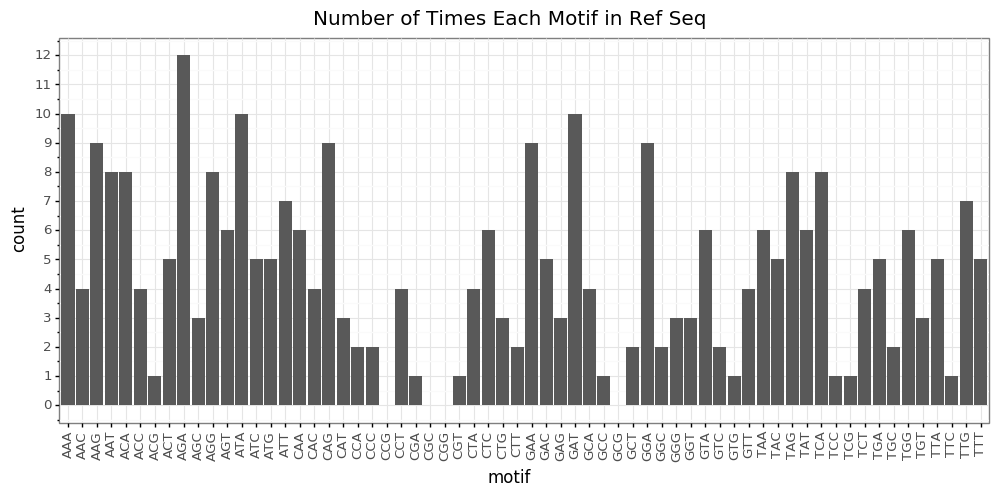

In [19]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
midrefseq = trimmedrefseq[130:170]
refseq_motif_counts = motif_counts(trimmedrefseq)
baseline_motif_counts_df = pd.DataFrame.from_dict(refseq_motif_counts, orient='index', columns=['count']).sort_values('count')
baseline_motif_counts_df = baseline_motif_counts_df.reset_index().rename(columns={'index': 'motif'})

plot_motif_counts = (ggplot(baseline_motif_counts_df, aes(x='motif', y='count')) +
                     geom_bar(stat='identity') + 
                     scale_y_continuous(breaks=range(0, 13, 1)) + 
                     labs(title='Number of Times Each Motif in Ref Seq') +
                     theme(axis_text_x=element_text(angle=90),
                           figure_size=(12, 5),
                          )
                    )

_ = plot_motif_counts.draw()

In [20]:
# deal with '-' and '_' discrepencies in sample names
df_samplenames = []
for sample in samplenames:
    df_samplename = sample.replace('_', '-')
    df_samplenames.append(df_samplename)

In [21]:
# csvs of processed reads with mutation information placed in this directory
# This is useful for re-running and modifying analyses, but can probably be changed/removed for final analyses.
csvsdir = os.path.join(resultsdir, 'mutinfo_csvs')
if not os.path.isdir(csvsdir):
    os.mkdir(csvsdir)

In [22]:
if use_existing == 'no': # only remake `csv`s if specified.
    for sample in df_samplenames:
        print(f"Processing reads for {sample}...")
        bcinfo_file = f"{countsdir}/{sample}_bcinfo.csv.gz"
        bcinfo_df = pd.read_csv(bcinfo_file)
        bcinfo_df_retained = bcinfo_df[bcinfo_df['Retained'] == True].reset_index(drop=True)
        bcinfo_df_retained['mid_seq'] = bcinfo_df_retained['Consensus'].apply(lambda x: x[130:170])
        bcinfo_df_retained['mid_subs'] = bcinfo_df_retained['mid_seq'].apply(getSubstitutions_Nokay_maskG, args=(midrefseq,))
        bcinfo_df_retained['n_mid_subs'] = bcinfo_df_retained['mid_subs'].apply(get_n_subs)     
        bcinfo_df_retained['subs'] = bcinfo_df_retained['Consensus'].apply(getSubstitutions_Nokay, args=(trimmedrefseq,))
        bcinfo_df_retained['n_subs'] = bcinfo_df_retained['subs'].apply(get_n_subs)
        bcinfo_df_retained['n_ga_subs'] = bcinfo_df_retained['subs'].apply(get_n_ga_subs)
        bcinfo_df_retained['sub_tups'] = bcinfo_df_retained['subs'].apply(subs_to_motifs, args=(trimmedrefseq,))
        bcinfo_df_retained['Sample'] = [sample]*len(bcinfo_df_retained)
        bcinfo_df_retained.to_csv(f"{csvsdir}/{sample}.csv")       

## Read in data and filter on the number of mutations in the middle of the sequence

In [23]:
mutinfo_dfs = {}
sub_count_dfs = {}
ga_sub_count_dfs = {}
for sample in df_samplenames:
    print(f"Reading in data for {sample}...")
    sample_mutinfo_df = pd.read_csv(f"{csvsdir}/{sample}.csv").fillna(value='')
    sample_mutinfo_df = sample_mutinfo_df[sample_mutinfo_df['n_mid_subs'] <= 3]
    sub_count_df = pd.DataFrame({'n_sub_count': sample_mutinfo_df.groupby('n_subs').size()}).reset_index()
    sub_count_df['n_sub_freq'] = sub_count_df['n_sub_count'] / sum(sub_count_df['n_sub_count'])
    ga_sub_count_df = pd.DataFrame({'n_ga_sub_count': sample_mutinfo_df.groupby('n_ga_subs').size()}).reset_index()
    ga_sub_count_df['n_ga_sub_freq'] = ga_sub_count_df['n_ga_sub_count'] / sum(ga_sub_count_df['n_ga_sub_count'])
    ga_sub_count_dfs[sample] = ga_sub_count_df
    sub_count_dfs[sample] = sub_count_df    
    mutinfo_dfs[sample] = sample_mutinfo_df

Reading in data for PLASMIDCTRL...
Reading in data for NoA3-1...
Reading in data for A3G-1...
Reading in data for A3C-1...
Reading in data for A3CE68A-1...
Reading in data for COTD-1...
Reading in data for COTDE254A-1...
Reading in data for COTDE68AE254A-1...
Reading in data for I188-1...
Reading in data for I188E68A-1...
Reading in data for COII-1...
Reading in data for COIIE68AE254A-1...
Reading in data for NoA3-2...
Reading in data for A3G-2...
Reading in data for A3C-2...
Reading in data for A3CE68A-2...
Reading in data for COTD-2...
Reading in data for COTDE254A-2...
Reading in data for COTDE68AE254A-2...
Reading in data for I188-2...
Reading in data for I188E68A-2...
Reading in data for COII-2...
Reading in data for COIIE68AE254A-2...


## Begin Sequence Analysis


In [24]:
read_count_dict = {'Sample': [], 'Total_Reads': [], 'Reads_with_Subs': [], 'Reads_with_2+_Subs': [],
                   'Reads_with_GA_Subs': [], 'Reads_with_2+_GA_Subs': [], '%_Reads_Sub': [], 
                   '%_Reads_2+_Subs': [], '%_Reads_GA_Sub': [], '%_Reads_2+_GA_Subs': []}

for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    sample_reads = len(sample_df)
    sample_sub_reads = len(sample_df[sample_df['n_subs'] > 0])
    sample_2ormoresubs_reads = len(sample_df[sample_df['n_subs'] > 1])
    sample_ga_sub_reads = len(sample_df[sample_df['n_ga_subs'] > 0])
    sample_2ormore_ga_subs_reads = len(sample_df[sample_df['n_ga_subs'] > 1])
    read_count_dict['Sample'].append(sample) 
    read_count_dict['Total_Reads'].append(sample_reads)
    read_count_dict['Reads_with_Subs'].append(sample_sub_reads)
    read_count_dict['Reads_with_2+_Subs'].append(sample_2ormoresubs_reads)
    read_count_dict['Reads_with_GA_Subs'].append(sample_ga_sub_reads)
    read_count_dict['Reads_with_2+_GA_Subs'].append(sample_2ormore_ga_subs_reads)
    read_count_dict['%_Reads_Sub'].append(round(sample_sub_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_2+_Subs'].append(round(sample_2ormoresubs_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_GA_Sub'].append(round(sample_ga_sub_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_2+_GA_Subs'].append(round(sample_2ormore_ga_subs_reads/sample_reads*100, 2))
read_count_df = pd.DataFrame.from_dict(read_count_dict, orient='columns')


## Combine technical replicates

In [25]:
plasmid_read_counts = read_count_df.iloc[0]
read_count_df_rep1 = read_count_df.iloc[1:12].copy()
read_count_df_rep1['Sample'] = read_count_df_rep1['Sample'].str[:-2]
read_count_df_rep1 = read_count_df_rep1.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)

read_count_df_rep2 = read_count_df.iloc[12:].copy()
read_count_df_rep2['Sample'] = read_count_df_rep2['Sample'].str[:-2]
samples2 = read_count_df_rep2['Sample']
read_count_df_rep2 = read_count_df_rep2.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)

for col in ['Total_Reads', 'Reads_with_Subs', 'Reads_with_2+_Subs', 'Reads_with_GA_Subs', 'Reads_with_2+_GA_Subs']:
    read_count_df_rep1[col] = read_count_df_rep1[col].astype(int)
    read_count_df_rep2[col] = read_count_df_rep2[col].astype(int)


read_counts_reps_summed = pd.concat([read_count_df_rep1, read_count_df_rep2]).groupby(['Sample']).sum().reset_index()
read_counts_reps_summed['%_Reads_Sub'] = round((read_counts_reps_summed['Reads_with_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_2+_Subs'] = round((read_counts_reps_summed['Reads_with_2+_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_GA_Sub'] = round((read_counts_reps_summed['Reads_with_GA_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_2+_GA_Subs'] = round((read_counts_reps_summed['Reads_with_2+_GA_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed = read_counts_reps_summed.append(plasmid_read_counts)
display(read_counts_reps_summed)

,Sample,Total_Reads,Reads_with_Subs,Reads_with_2+_Subs,Reads_with_GA_Subs,Reads_with_2+_GA_Subs,%_Reads_Sub,%_Reads_2+_Subs,%_Reads_GA_Sub,%_Reads_2+_GA_Subs
0,A3C,268874,83732,28384,73445,25216,31.14,10.56,27.32,9.38
1,A3CE68A,302407,33655,5410,14792,3940,11.13,1.79,4.89,1.30
2,A3G,739952,656629,616044,650698,612846,88.74,83.25,87.94,82.82
3,COII,601985,292617,165605,273843,157505,48.61,27.51,45.49,26.16
4,COIIE68AE254A,727830,77981,11709,30664,8038,10.71,1.61,4.21,1.10
5,COTD,905916,277425,96247,234575,84235,30.62,10.62,25.89,9.30
6,COTDE254A,355151,104025,32736,84853,27434,29.29,9.22,23.89,7.72
7,COTDE68AE254A,734866,81411,15679,30470,11901,11.08,2.13,4.15,1.62
8,I188,454940,241596,134488,224862,126110,53.11,29.56,49.43,27.72
9,I188E68A,742263,80749,14694,37948,11259,10.88,1.98,5.11,1.52


# Make bar plots of # templates (y-axis) vs mutation count per template (x-axis) for each sample. 

Subset on G-to-A mutations

In [26]:
all_samples_df = pd.DataFrame()
for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    all_samples_df = all_samples_df.append(sample_df, ignore_index=True)

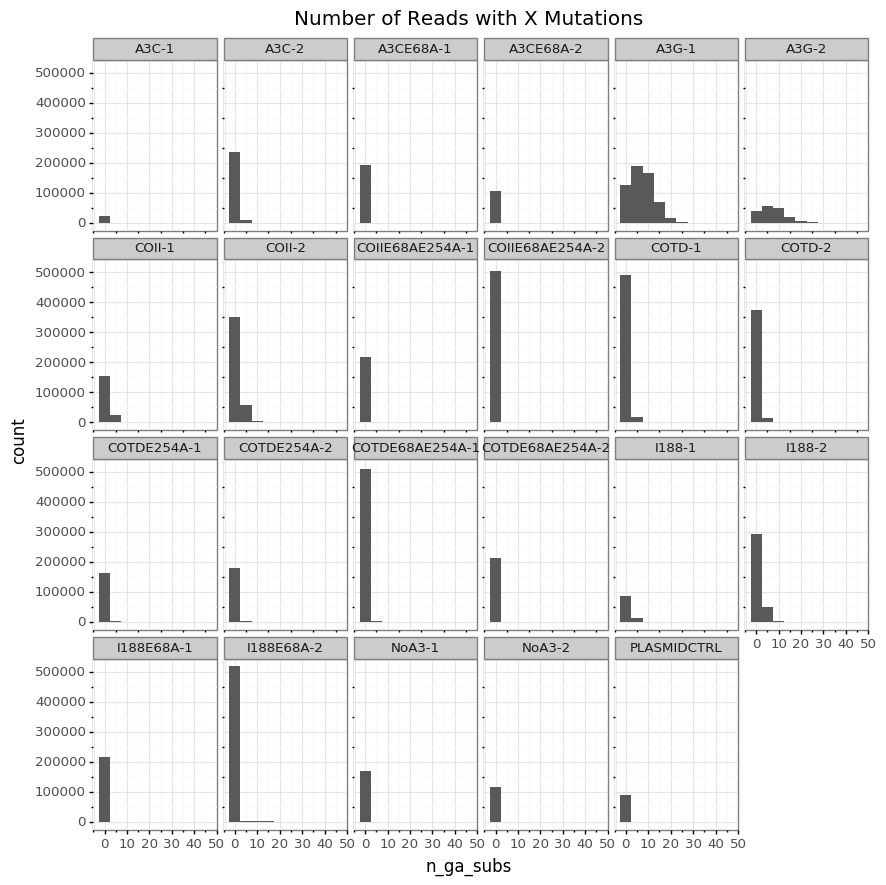

In [27]:
mut_ga_count_plot = (ggplot(all_samples_df, aes(x='n_ga_subs')) +
                  geom_histogram(binwidth=5) + 
                  facet_wrap('~ Sample', ncol=6) +
                  labs(title='Number of Reads with X Mutations') +
                  theme(axis_text_x=element_text(angle=0),
                        figure_size=(10, 10),
                       )
                  )
_ = mut_ga_count_plot.draw()

## Frequency of reads for each sample with that number of substitutions rather than count.

Still subsetting on G-to-A mutations.

As seen above, technical replicates have same distributions, just different count numbers. So averaging
frequencies between replicates.

In [28]:
all_ga_sub_counts_df = pd.DataFrame()
rep1_ga_sub_counts_df = pd.DataFrame()
rep2_ga_sub_counts_df = pd.DataFrame()
for sample in df_samplenames:
    sample_binned_dict = {}
    sample_df = ga_sub_count_dfs[sample]
    for i in range(0, 10):
        if i in sample_df['n_ga_subs'].to_list():
            idx = sample_df.index[sample_df['n_ga_subs'] == i][0]
            sample_binned_dict[str(i)] = sample_df.at[idx, 'n_ga_sub_count']
        else:
            sample_binned_dict[str(i)] = 0
    sample_binned_dict['10+'] = sum(sample_df[sample_df['n_ga_subs'] >= 10]['n_ga_sub_count'])
    assert(sum(sample_df['n_ga_sub_count']) == sum(sample_binned_dict.values()))
    sample_binned_df = pd.DataFrame.from_dict(sample_binned_dict, orient='index').reset_index().rename(columns={'index': 'n_ga_subs', 0: 'n_ga_sub_count'})
    sample_binned_df['n_ga_sub_freq'] = sample_binned_df['n_ga_sub_count'] / sum(sample_binned_df['n_ga_sub_count']) * 100
    sample_binned_df['Sample'] = [sample.split('-')[0]]*len(sample_binned_df)
    if sample == 'PLASMIDCTRL':
        plasmid_binned_df = sample_binned_df
    elif '-1' in sample:
        rep1_ga_sub_counts_df = rep1_ga_sub_counts_df.append(sample_binned_df, ignore_index=True)
    elif '-2' in sample:
        rep2_ga_sub_counts_df = rep2_ga_sub_counts_df.append(sample_binned_df, ignore_index=True)
    else:
        print(f'Invalid sample name {sample}')
        break

reps_ga_concat = pd.concat((rep1_ga_sub_counts_df, rep2_ga_sub_counts_df))
ga_by_row_index = reps_ga_concat.groupby(reps_ga_concat.index)
reps_ga_avg = pd.DataFrame()
reps_ga_avg['n_ga_sub_freq'] = ga_by_row_index['n_ga_sub_freq'].mean()
reps_ga_avg['n_ga_sub_count'] = ga_by_row_index['n_ga_sub_count'].sum()
reps_ga_avg['n_ga_subs'] = rep1_ga_sub_counts_df['n_ga_subs']
reps_ga_avg['Sample'] = rep1_ga_sub_counts_df['Sample']
    
    
all_ga_sub_counts_df = pd.concat((reps_ga_avg, plasmid_binned_df), ignore_index=True, sort=True)

In [29]:
display(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'A3G'])

,Sample,n_ga_sub_count,n_ga_sub_freq,n_ga_subs
11,A3G,89254,12.047986,0
12,A3G,37852,5.121133,1
13,A3G,37713,5.089946,2
14,A3G,42521,5.683068,3
15,A3G,46946,6.342105,4
16,A3G,49984,6.738876,5
17,A3G,52246,7.055807,6
18,A3G,52576,7.095491,7
19,A3G,51579,6.992135,8
20,A3G,47387,6.388635,9


In [30]:
display(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'NoA3'])

,Sample,n_ga_sub_count,n_ga_sub_freq,n_ga_subs
0,NoA3,266955,92.550398,0
1,NoA3,15179,5.240197,1
2,NoA3,2310,0.799907,2
3,NoA3,653,0.222770,3
4,NoA3,291,0.099947,4
5,NoA3,175,0.061228,5
6,NoA3,153,0.052772,6
7,NoA3,120,0.042199,7
8,NoA3,111,0.039031,8
9,NoA3,132,0.046514,9


In [31]:
facet_dict_ga = {'PLASMIDCTRL': f"Plasmid Ctrl\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'PLASMIDCTRL']['n_ga_sub_count']))}", 
              'NoA3': f"No A3\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'NoA3']['n_ga_sub_count']))}",
              'A3G': f"A3G\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'A3G']['n_ga_sub_count']))}",
              'A3C': f"A3C\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'A3C']['n_ga_sub_count']))}",
              'A3CE68A': f"A3C E68A\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'A3CE68A']['n_ga_sub_count']))}",
              'COTD': f"A3C-A3C\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'COTD']['n_ga_sub_count']))}",
              'COTDE254A': f"A3C-A3C E254A\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'COTDE254A']['n_ga_sub_count']))}",
              'COTDE68AE254A': f"A3C-A3C E68A E254A\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'COTDE68AE254A']['n_ga_sub_count']))}",
              'I188': f"I188\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'I188']['n_ga_sub_count']))}",
              'I188E68A': f"I188 E68A\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'I188E68A']['n_ga_sub_count']))}",
              'COII': f"I188-I188\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'COII']['n_ga_sub_count']))}",
              'COIIE68AE254A': f"I188-I188 E68A E254A\n n = {int(sum(all_ga_sub_counts_df[all_ga_sub_counts_df['Sample'] == 'COIIE68AE254A']['n_ga_sub_count']))}"
             }

def facet_labeller_ga(label):
    return(facet_dict_ga[label])

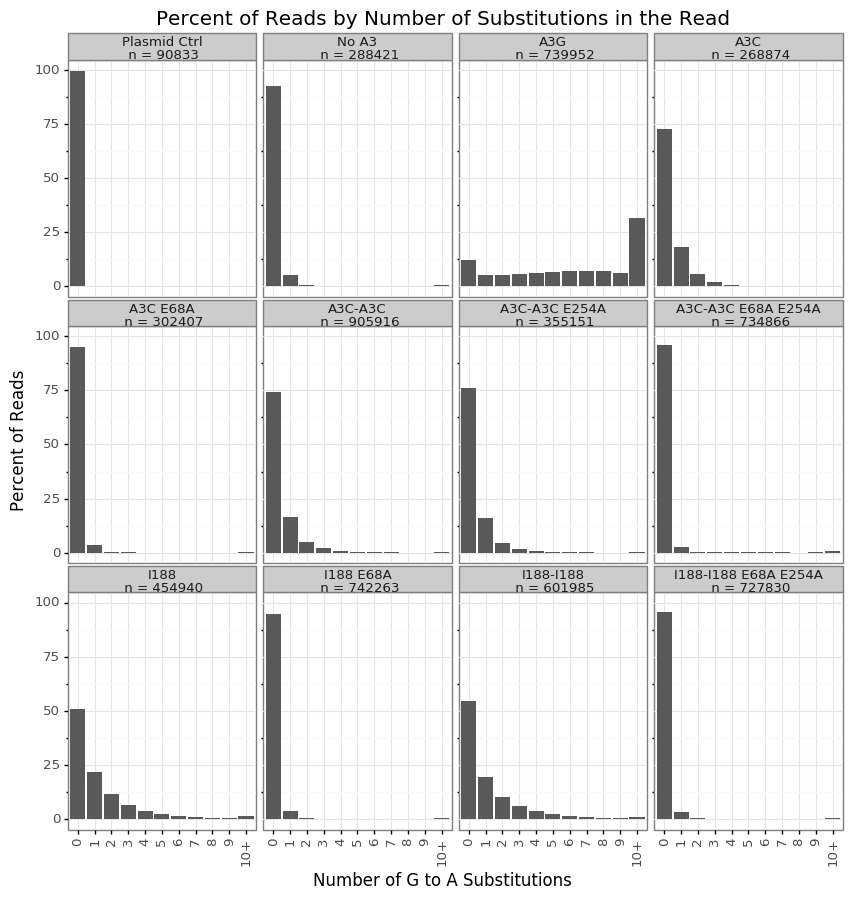

In [32]:
x_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
x_cat = pd.Categorical(all_ga_sub_counts_df['n_ga_subs'], categories=x_list)

facet_list = ["PLASMIDCTRL", 'NoA3', 'A3G', 'A3C', 'A3CE68A', 'COTD', 'COTDE254A', 'COTDE68AE254A',
              'I188', 'I188E68A', 'COII', 'COIIE68AE254A']
facet_cat = pd.Categorical(all_ga_sub_counts_df['Sample'], categories=facet_list)


all_ga_sub_counts_df = all_ga_sub_counts_df.assign(x_cat = x_cat)
all_ga_sub_counts_df = all_ga_sub_counts_df.assign(facet_cat = facet_cat)

ga_mut_freq_plot = (ggplot(all_ga_sub_counts_df, aes(x='x_cat', y='n_ga_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=4, labeller=facet_labeller_ga) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(10, 10),
                        strip_background_x=element_rect(height=1/9),
                       )
                  )

_ = ga_mut_freq_plot.draw()

In [33]:
# Replace '10+' string with '10' for plotting line plots
all_ga_sub_counts_df['n_ga_subs'].replace('10+', '10', inplace=True)
all_ga_sub_counts_df['n_ga_subs'] = all_ga_sub_counts_df['n_ga_subs'].astype(int)

### Looking at the distributions of line plots allows for easier comparison of mutation per read distributions

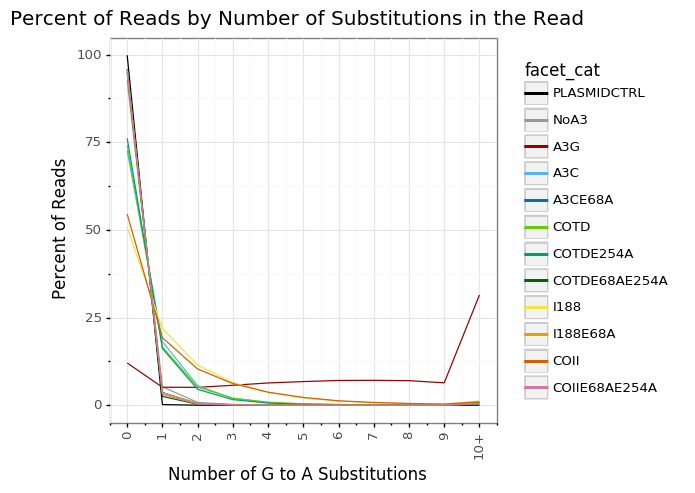

In [34]:
line_palette = ['#000000', '#999999', '#990000', '#56B4E9', '#0072B2', '#66CC00', '#009E73','#006400', '#F0E442', 
             '#E69F00', '#D55E00',  '#CC79A7']

ga_mut_freq_line_plot = (ggplot(all_ga_sub_counts_df, aes(x='n_ga_subs', y='n_ga_sub_freq', color='facet_cat')) +
                         geom_line() +
                         scale_color_manual(values=line_palette) +
                         #facet_wrap('~ facet_cat', ncol=4, labeller=facet_labeller_ga) +
                         labs(title='Percent of Reads by Number of Substitutions in the Read') +
                         ylab('Percent of Reads') +
                         xlab('Number of G to A Substitutions') +
                         theme(axis_text_x=element_text(angle=90),
                               figure_size=(5, 5),
                               strip_background_x=element_rect(height=1/9),
                              ) +
                         scale_x_continuous(breaks=range(0, 11, 1), labels=['0', '1', '2', '3', '4', '5', 
                                                                            '6', '7', '8', '9', '10+'])
                          )

_ = ga_mut_freq_line_plot.draw()

In [35]:
plt.close('all')

### Plot subsets of graphs for publication:

Again, we are subsetting only on G to A substitutions.

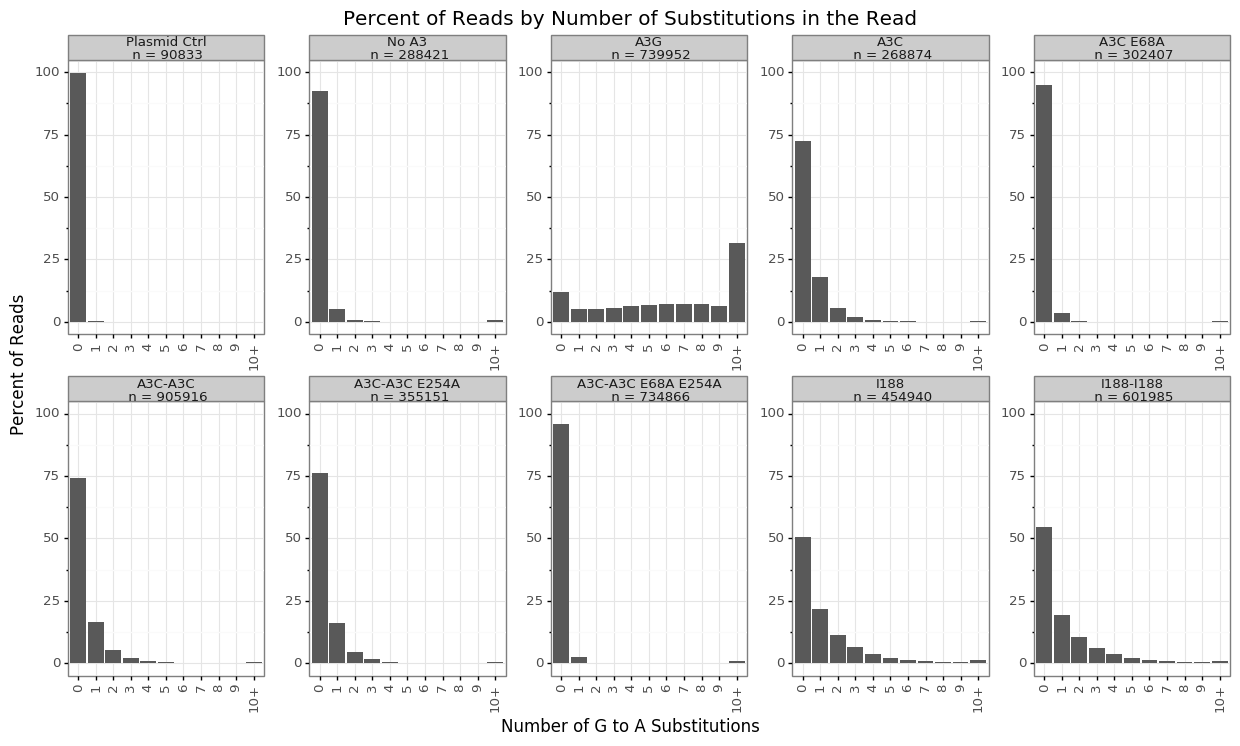

In [36]:
NoI188E68A = pd.concat([all_ga_sub_counts_df[(all_ga_sub_counts_df['Sample'] != 'I188E68A') &
                                             (all_ga_sub_counts_df['Sample'] != 'COIIE68AE254A')]])

facet_list = ["PLASMIDCTRL", 'NoA3', 'A3G', 'A3C', 'A3CE68A', 'COTD', 'COTDE254A', 'COTDE68AE254A',
              'I188', 'COII']
facet_cat = pd.Categorical(NoI188E68A['Sample'], categories=facet_list)

NoI188E68A = NoI188E68A.assign(facet_cat = facet_cat)

ga_mut_freq_plot = (ggplot(NoI188E68A, aes(x='x_cat', y='n_ga_sub_freq')) +
                  geom_bar(stat='identity') + 
                  scale_y_continuous(limits=(0, 100)) +
                  facet_wrap('~ facet_cat', ncol=5, labeller=facet_labeller_ga, scales='free') +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(15, 8),
                        strip_background_x=element_rect(height=1/11),
                        panel_spacing=(0.45)
                       )
                  )

_ = ga_mut_freq_plot.draw()


In [37]:
plt.close('all')

## Analyze Mutation Motifs

Extract the substitution and 5' and 3' nucleotide identities information for each sample.

In [38]:
dfs_to_make_pwms = {}
print(f"Extracting motif substitution information...")
for sample in df_samplenames:
    print(sample)
    sample_df = mutinfo_dfs[sample]
    sub_df = sample_df[sample_df['n_subs'] != 0].reset_index(drop=True)
    sample_motif_counts = pd.DataFrame(columns = ['sub',"5'", "3'", 'motif', 'count', 'freq', 'sample'])
    
    sub_df['sub_tups'] = sub_df['sub_tups'].apply(literal_eval)
    sub_tups_list = sub_df['sub_tups'].to_list()
    sub_info_list=[]
    sub_info_list = [sub_tup for sub_tups in sub_tups_list for sub_tup in sub_tups]
    sub_info_df = pd.DataFrame(sub_info_list, columns=["5'", 'sub', "3'", "motif"])
    dfs_to_make_pwms[sample] = sub_info_df # save these dataframes for making PWMs below

Extracting motif substitution information...
PLASMIDCTRL
NoA3-1
A3G-1
A3C-1
A3CE68A-1
COTD-1
COTDE254A-1
COTDE68AE254A-1
I188-1
I188E68A-1
COII-1
COIIE68AE254A-1
NoA3-2
A3G-2
A3C-2
A3CE68A-2
COTD-2
COTDE254A-2
COTDE68AE254A-2
I188-2
I188E68A-2
COII-2
COIIE68AE254A-2


## Make PPMs (and PWMs) for mutation sites. 

But don't make logo plots. The PPMs will be used to make logo plots based on entropy (below).

Start by looking at any site with a substitution, then subset on G->A as I think that's what Mollie and Michael will want.

In [39]:
rep1_pfm_dict = {}
rep2_pfm_dict = {}
for sample in df_samplenames:
    print(f"Making pfm for {sample}...")
    sample_sub_info = dfs_to_make_pwms[sample].copy()
    sample_sub_info['0'] = sample_sub_info['sub'].astype(str).str[0]
    sample_sub_info.rename(columns={"3'": '1', "5'": '-1'}, inplace=True)
    sample_sub_info.drop(['motif', 'sub'], axis=1, inplace=True)
    
    sample_pfm = pd.DataFrame(columns=['-1', '0', '1'], index=['A', 'C', 'G', 'T'])
    nucleotides = ['A', 'C', 'G', 'T']
    for site in ['-1', '0', '1']:
        for nt in nucleotides:
            sample_pfm.at[nt, site] = len(sample_sub_info[sample_sub_info[site] == nt])
        
    assert(len(sample_sub_info) == sum(sample_pfm['0']))
        
    if sample == 'PLASMIDCTRL':
        plasmid_pfm = sample_pfm
    elif '-1' in sample:
        rep1_pfm_dict[sample[:-2]] = sample_pfm
    elif '-2' in sample:
        rep2_pfm_dict[sample[:-2]] = sample_pfm
    else:
        print(f'Invalid sample name {sample}')
        break

Making pfm for PLASMIDCTRL...
Making pfm for NoA3-1...
Making pfm for A3G-1...
Making pfm for A3C-1...
Making pfm for A3CE68A-1...
Making pfm for COTD-1...
Making pfm for COTDE254A-1...
Making pfm for COTDE68AE254A-1...
Making pfm for I188-1...
Making pfm for I188E68A-1...
Making pfm for COII-1...
Making pfm for COIIE68AE254A-1...
Making pfm for NoA3-2...
Making pfm for A3G-2...
Making pfm for A3C-2...
Making pfm for A3CE68A-2...
Making pfm for COTD-2...
Making pfm for COTDE254A-2...
Making pfm for COTDE68AE254A-2...
Making pfm for I188-2...
Making pfm for I188E68A-2...
Making pfm for COII-2...
Making pfm for COIIE68AE254A-2...


In [40]:
print("Combine PFMs (sum reads for replicates)...")
summed_pfms_dict = {}
num_subs_dict = {}

summed_pfms_dict['PLASMIDCTRL'] = plasmid_pfm
num_subs_dict['PLASMIDCTRL'] = sum(plasmid_pfm['0'])
for samplename in rep1_pfm_dict:
    summed_pfms_dict[samplename] = (rep1_pfm_dict[samplename] + rep2_pfm_dict[samplename])
    num_subs_dict[samplename] = sum(summed_pfms_dict[samplename]['0'])


Combine PFMs (sum reads for replicates)...


In [41]:
print('Making PWMs...')
pseudocount = 1
pwms_dict = {}
background = summed_pfms_dict['NoA3']
background = background + pseudocount
background_ppm = background / background.sum(axis=0)

ppms_dict = {}

for samplename in summed_pfms_dict:
    sample_pfm = summed_pfms_dict[samplename]
    sample_pfm_pseudo = sample_pfm + (sample_pfm.sum(axis=0) / background.sum(axis=0))
    sample_ppm = sample_pfm_pseudo / sample_pfm_pseudo.sum(axis=0)
    ppms_dict[samplename] = sample_ppm
    pwms_dict[samplename] = np.log2((sample_ppm / background_ppm).astype('float64'))

Making PWMs...


## Make Logos based on Entropy

Citations:

For overall math:

https://weblogo.berkeley.edu/Crooks-2004-GR-WebLogo.pdf

For background corrections:
1. Stormo, G.D. 1998. Information content and free energy in DNA-protein interactions. J. Theor. Biol. 195: 135–137.
2. Gorodkin, J., Heyer, L.J., Brunak, S., and Stormo, G.D. 1997. Displaying the information contents of structural RNA alignments: The structure logos. Comput. Appl. Biosci. 13: 583–586.

In [42]:
def entropy(ppm):
    entropy_df = pd.DataFrame(columns=['-1', '0', '1'], index=['0'])
    for i in ppm.columns:
        entropy = 0.
        site_ppm = ppm[i].to_list()      
        for j in site_ppm:
            entropy -= j * np.log2(j)
        entropy_df.at['0', i] = entropy
    return(entropy_df)

In [43]:
print('Example with maximum entropy.')
equal_ppm = pd.DataFrame({'-1':[0.25, 0.25, 0.25, 0.25], '0': [0.25, 0.25, 0.25, 0.25], '1': [0.25, 0.25, 0.25, 0.25]})
print(entropy(equal_ppm))

print('\nExample with minimum entropy.')
one_nt_ppm = pd.DataFrame({'-1':[0.0001, 0.0001, 0.0001, 0.9997], '0': [0.001, 0.001, 0.997, 0.001], '1': [0.001, 0.001, 0.997, 0.001]})
print(entropy(one_nt_ppm))


Example with maximum entropy.
  -1  0  1
0  2  2  2

Example with minimum entropy.
           -1          0          1
0  0.00441906  0.0342189  0.0342189


Without the background frequency correction, the max entropy is 2.
With the background frequency correction, the max entropy is 0.

In [44]:
max_ent = 2

## Entropy calculations

I am correcting for the background using the `PlasmidCtrl` frequencies in order to calculate corrected frequencies (similar to 'type 2 logo' plots (described in Gorodkin, et al., 1997)). From these corrected frequencies, I construct logo plots more like a 'type 1 logo' or those described in Crooks, et al.

Should I add back in the other analyses?

In [45]:
sample_height_dict = {}

bg_ppm = ppms_dict['PLASMIDCTRL']

for samplename in ppms_dict:
    sample_ppm = ppms_dict[samplename]
    bg_corrected_ppm = pd.DataFrame(columns = ['-1', '0', '1'], index=['A', 'C', 'G', 'T'])
    for i in sample_ppm.columns:
        sum_bg_correction = sum(sample_ppm[i]/bg_ppm[i])
        bg_corrected_ppm[i] = (sample_ppm[i]/bg_ppm[i])/sum_bg_correction
    sample_entropy = entropy(bg_corrected_ppm)
    sample_ic = max_ent - (sample_entropy)
    
    sample_height = pd.DataFrame(columns = ['-1', '0', '1'], index=['A', 'C', 'G', 'T'])
    for j in bg_corrected_ppm.columns:
        site_ic = float(sample_ic[j])
        sample_height[j] = bg_corrected_ppm[j].apply(lambda x: (x*site_ic))
    
    sample_height_dict[samplename] = sample_height

In [46]:
logo_labels_dict = {'PLASMIDCTRL': "Plasmid Ctrl", 
              'NoA3': "No A3",
              'A3G': "A3G",
              'A3C': "A3C",
              'A3CE68A': "A3C E68A",
              'COTD': "A3C-A3C",
              'COTDE254A': "A3C-A3C E254A",
              'COTDE68AE254A': "A3C-A3C E68A E254A",
              'I188': "I188",
              'I188E68A': "I188 E68A",
              'COII': "I188-I188",
              'COIIE68AE254A': "I188-I188 E68A E254A"
             }

Making entropy logo plots from PPMs with plasmid control as background correction...


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/dmslogo/logo.py:443: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)
/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/dmslogo/facet.py:193: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


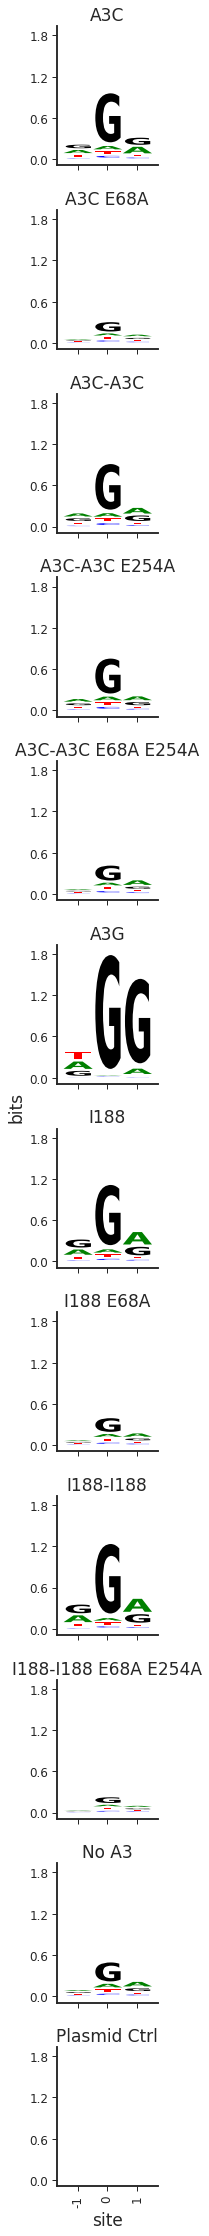

In [47]:
print('Making entropy logo plots from PPMs with plasmid control as background correction...')
melted_entropy_combined = pd.DataFrame(columns = ['nt', 'site', 'bits', 'color', 'sample'])
for samplename in sample_height_dict:
    sample_logo = sample_height_dict[samplename].reset_index()
    melted_logo = sample_logo.melt(id_vars='index')
    melted_logo.rename(columns={'index':'nt', 'variable':'site', 'value':'bits'}, inplace=True)
    melted_logo['site'] = melted_logo['site'].astype(int)
    melted_logo['color'] = ['green', 'blue', 'black', 'red', 'green', 'blue', 'black', 'red', 'green', 'blue', 'black', 'red']
    melted_logo['sample'] = [logo_labels_dict[samplename]]*len(melted_logo)
    melted_entropy_combined = melted_entropy_combined.append(melted_logo)
    
fig, axes = dmslogo.facet_plot(melted_entropy_combined,
                               gridrow_col='sample',
                               x_col='site',
                               show_col=None,
                               draw_logo_kwargs=dict(letter_col='nt',
                                                     letter_height_col='bits',
                                                     color_col='color')
                            )


Making entropy logo plots from PPMs with Plasmid Ctrl as background correction...


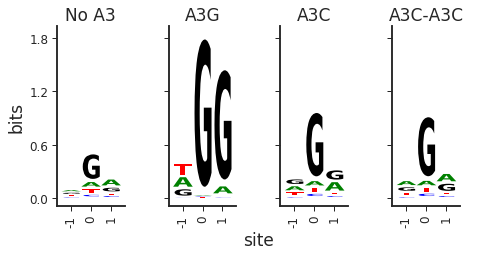

In [48]:
print('Making entropy logo plots from PPMs with Plasmid Ctrl as background correction...')
melted_entropy_combined = pd.DataFrame(columns = ['nt', 'site', 'bits', 'color', 'sample'])
logos_to_plot = {'A3G': 'B', 'A3C': 'C', 'COTD': 'D', 'NoA3': 'A'} #, 'PLASMIDCTRL']
for samplename in logos_to_plot:
    sample_logo = sample_height_dict[samplename].reset_index()
    melted_logo = sample_logo.melt(id_vars='index')
    melted_logo.rename(columns={'index':'nt', 'variable':'site', 'value':'bits'}, inplace=True)
    melted_logo['site'] = melted_logo['site'].astype(int)
    melted_logo['color'] = ['green', 'blue', 'black', 'red', 'green', 'blue', 'black', 'red', 'green', 'blue', 'black', 'red']
    melted_logo['sample'] = [logo_labels_dict[samplename]]*len(melted_logo)
    melted_logo['order'] = [logos_to_plot[samplename]]*len(melted_logo)
    melted_entropy_combined = melted_entropy_combined.append(melted_logo)
    
melted_entropy_combined['sample'] = pd.Categorical(melted_entropy_combined['sample'], 
                                                  ordered=True,
                                                  categories=['No A3', 'A3G', 'A3C', 'A3C-A3C'])
        
fig, axes = dmslogo.facet_plot(melted_entropy_combined,
                               gridcol_col='sample',
                               x_col='site',
                               show_col=None,
                               draw_logo_kwargs=dict(letter_col='nt',
                                                     letter_height_col='bits',
                                                      color_col='color')
                            )
